In [1]:
import os
import yaml
import torch
import numpy as np
import scipy.io as sio
from os.path import join
from model_cbam import RDUNet
from skimage import io
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import cv2
from utils import build_ensemble, separate_ensemble, predict_ensemble, mod_pad, mod_crop

In [2]:
from skimage import io, color, img_as_ubyte
def load_image(image_path, channels):
    """
    Load image and change it color space from RGB to Grayscale if necessary.
    :param image_path: str
        Path of the image.
    :param channels: int
        Number of channels (3 for RGB, 1 for Grayscale)
    :return: numpy array
        Image loaded.
    """
    image = io.imread(image_path,format='jpg')
    if image.ndim == 3 and channels == 1:       # Convert from RGB to Grayscale and expand dims.
        image = img_as_ubyte(color.rgb2gray(image))
        return np.expand_dims(image, axis=-1)
    elif image.ndim == 2 and channels == 1:     # Handling grayscale images if needed.
        if image.dtype != 'uint8':
            image = img_as_ubyte(image)
        return np.expand_dims(image, axis=-1)

    return image

In [3]:
with open('config.yaml', 'r') as stream:
        config = yaml.safe_load(stream)

model_params = config['model']
test_params = config['test']
n_channels = model_params['channels']

model_params = config['model']
model = RDUNet(**model_params)

device = torch.device(test_params['device'])
print("Using device: {}".format(device))

state_dict = torch.load("model_color-120-3.9796e-02-25.3408-0.8360.pth",map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()

Using device: cpu


RDUNet(
  (input_block): InputBlock(
    (conv_1): depthwise_separable_conv(
      (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
      (pointwise): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (conv_2): depthwise_separable_conv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (actv_1): PReLU(num_parameters=32)
    (actv_2): PReLU(num_parameters=32)
  )
  (block_0_0): DenoisingBlock(
    (conv_0): depthwise_separable_conv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (pointwise): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (conv_1): depthwise_separable_conv(
      (depthwise): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
 

In [4]:
import matplotlib.pyplot as plt 
image_test = load_image("test_gan.jpg", 3)
padding = True

# image_test, size = mod_pad(image_test, 8)
# image_test = np.transpose(image_test.copy(), (2, 0, 1))
# image_test = image_test / 255.
# image_test = torch.from_numpy(np.expand_dims(image_test, 0)).float() 
# with torch.no_grad():
#     image_test = image_test.to(device)
#     output = model(image_test)
# output = output.squeeze() 
# output = np.transpose(output, (1, 2, 0))
# output = output.numpy()

# output = (output*255).astype(np.uint8)

# io.imsave("3.jpg", output)
# # output = (255 * output).astype('uint8')
# plt.imshow(output)
# plt.show()
# del model
# del output


# for i in range(len(image_test)):
#     tensor = image_test[i].squeeze()
#     # Convert tensor to numpy array
#     numpy_array = tensor.numpy()
#     numpy_array = numpy_array
#     numpy_array = numpy_array.astype(np.uint8)

#     # Show image using matplotlib.pyplot.imshow()
#     plt.imshow(numpy_array.transpose(1, 2, 0))
#     plt.show()




image_test, size = mod_pad(image_test, 8)
image_test = build_ensemble(image_test, normalize=True)
y_pred, y_pred_ens = [], []
with torch.no_grad():
    y_hat_ens = predict_ensemble(model, image_test, device)
    y_hat_ens,y_hat = separate_ensemble(y_hat_ens, return_single=True)

    if padding:
        y_hat = y_hat[:size[0], :size[1], ...]
        y_hat_ens = y_hat_ens[:size[0], :size[1], ...]
y_hat = np.squeeze(y_hat)
y_hat_ens = np.squeeze(y_hat_ens)
io.imsave("1.jpg", y_hat)
io.imsave("2.jpg", y_hat_ens)
del model
del y_hat_ens,y_hat  

Lossy conversion from float32 to uint8. Range [-0.05732443928718567, 1.204342007637024]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


# create data test

In [11]:
import numpy as np
import cv2

# Load color image
img = cv2.imread('testtest.jpg',cv2.IMREAD_UNCHANGED)
cv2.imwrite("testtest.jpg",img)
print(img.shape)



(840, 594, 4)


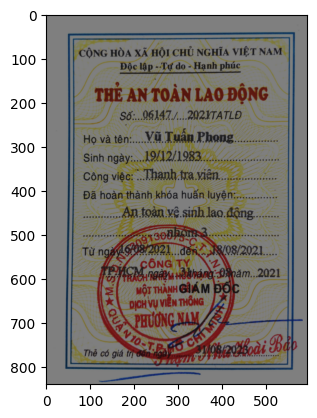

In [11]:
from PIL import Image
import numpy as np
import cv2
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
# Load an image
img = cv2.imread('test.jpg')
# img_array = np.array(img)
# print(img_array.shape)

seq = iaa.Sequential([
    iaa.pillike.EnhanceColor(0.5),
    iaa.Multiply(0.5)
])
# Apply augmentations
images_aug = seq.augment_images(img)
# images_aug = Image.fromarray(images_aug.astype(np.uint8))
# images_aug.save('testtest.jpg')
# print(images_aug.shape)
# del images_aug
# cv2.imwrite('testtest.jpg',images_aug)

plt.imshow(cv2.cvtColor(images_aug,cv2.COLOR_BGR2RGB))
plt.show()

In [15]:

from PIL import Image
from PIL import ImageEnhance
from scipy.ndimage.filters import gaussian_filter

import random 

/tmp/ipykernel_6498/2020488851.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [25]:

im = im*0.6
# io.imsave("testtest.jpg", noisy)
# image, noisy = list(image), list(noisy)
noisy = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
cv2.imwrite("testtest.jpg",noisy)

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [35]:
# import random module
import random
 
# generates a list with 3 random integers between 1 and 3
rand_list = random.sample(range(1, 5), 1) 
  
# prints the list 
print(rand_list) 



[3]
